# Imports

In [1]:
import numpy as np
import pickle
import os.path
from os.path import isfile, join
from os import path,listdir
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

In [2]:
from matplotlib.patches import PathPatch

def adjust_box_widths(g, fac):
    """
    Adjust the withs of a seaborn-generated boxplot.
    """

    # iterating through Axes instances
    for ax in g.axes:

        # iterating through axes artists:
        for c in ax.get_children():

            # searching for PathPatches
            if isinstance(c, PathPatch):
                # getting current width of box:
                p = c.get_path()
                verts = p.vertices
                verts_sub = verts[:-1]
                xmin = np.min(verts_sub[:, 0])
                xmax = np.max(verts_sub[:, 0])
                xmid = 0.5*(xmin+xmax)
                xhalf = 0.5*(xmax - xmin)

                # setting new width of box
                xmin_new = xmid-fac*xhalf
                xmax_new = xmid+fac*xhalf
                verts_sub[verts_sub[:, 0] == xmin, 0] = xmin_new
                verts_sub[verts_sub[:, 0] == xmax, 0] = xmax_new

                # setting new width of median line
                for l in ax.lines:
                    if np.all(l.get_xdata() == [xmin, xmax]):
                        l.set_xdata([xmin_new, xmax_new])

In [3]:
def plot_Dist(Day_Data,What_To_Plot = 'Condition', SwapColors = None, legend_on=True):
    fig = plt.figure(figsize=(12, 8))

    plt.subplot(2,2,1)
    sns.histplot(data = Day_Data.query("Stimulus == 'Left'"), x = 'OrientationChange', hue = What_To_Plot, stat = 'probability', element = 'poly', fill = False,common_norm=False,palette = SwapColors,legend = legend_on)
    plt.xlabel('')
    plt.title('Left')

    plt.subplot(2,2,2)
    sns.histplot(data = Day_Data.query("Stimulus == 'Right'"), x = 'OrientationChange', hue = What_To_Plot, stat = 'probability', element = 'poly', fill = False,common_norm=False,palette = SwapColors,legend = legend_on)
    plt.ylabel('')
    plt.xlabel('')
    plt.title('Right')

    plt.subplot(2,3,4)
    sns.histplot(data = Day_Data.query("Stimulus == 'Front'"), x = 'OrientationChange', hue = What_To_Plot, stat = 'probability', element = 'poly', fill = False,common_norm=False,palette = SwapColors,legend = legend_on)
    
    plt.title('Front')

    plt.subplot(2,3,5)
    sns.histplot(data = Day_Data.query("Stimulus == 'Back'"), x = 'OrientationChange', hue = What_To_Plot, stat = 'probability', element = 'poly', fill = False,common_norm=False,palette = SwapColors,legend = legend_on)
    plt.ylabel('')
    plt.title('Back')

    plt.subplot(2,3,6)
    sns.histplot(data = Day_Data.query("Stimulus == 'None'"), x = 'OrientationChange', hue = What_To_Plot, stat = 'probability', element = 'poly', fill = False,common_norm=False,palette = SwapColors,legend = legend_on)
    plt.ylabel('')
    plt.title('None')

    plt.show()

In [4]:
def get_CummulativeAngle(input_df):
    Cumm_turns = np.zeros((len(np.unique(input_df['FishID'])),30))

    Fishies = list(np.unique(input_df['FishID']))

    for fishcount, fish in enumerate(Fishies):
        numTrials = len(np.unique(input_df.query("FishID == '" + fish+"'")['TrialNum']))
        for trial in np.unique(input_df.query("FishID == '" + fish+"'")['TrialNum']):
            Changes = input_df.query("FishID == '" + fish+"'").query("TrialNum == " + str(trial))['OrientationChange']
            Cumm_turns[fishcount,trial] = Changes.sum()
    return Cumm_turns

def plot_CummulativeAngle(Data, legend_on=True):     
        
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    fig = plt.figure(figsize=(12, 8))

    plt.subplot(1,2,1)
    LeftData = get_CummulativeAngle(Data.query("Stimulus == 'Left'"))
    sns.heatmap(LeftData[np.argsort(LeftData.sum(axis=1)),:],square=True, linewidths=.5, cbar_kws={"shrink": .5},cmap = cmap,center = 0)
    plt.xlabel('')
    plt.title('Left')

    plt.subplot(1,2,2)
    RightData = get_CummulativeAngle(Data.query("Stimulus == 'Right'"))
    sns.heatmap(RightData[np.argsort(RightData.sum(axis=1))[::-1],:],square=True, linewidths=.5, cbar_kws={"shrink": .5},cmap = cmap,center = 0)
    plt.ylabel('')
    plt.xlabel('')
    plt.title('Right')

    plt.show()

In [5]:
def get_NumTurns(input_df,What_To_Plot):
    df = pd.DataFrame(columns = [What_To_Plot,'FishID', 'RelativeStraight'])

    Plotters = list(np.unique(input_df[What_To_Plot]))
    for plot_data in Plotters:
        condition_df = input_df.query(What_To_Plot+ " == '" + plot_data+"'")
        Fishies = list(np.unique(condition_df['FishID']))
        stats = []

        for fish in Fishies:
            Changes = condition_df.query("FishID == '" + fish+"'")['OrientationChange']
            stats.append(float(len(Changes)))

        df_temp = pd.DataFrame({
                    What_To_Plot:[plot_data]*len(stats),
                    'FishID': Fishies, 
                    'RelativeStraight': stats 
                    })
        df = df.append(df_temp)
    return df

def plot_NumTurns(Day_Data,What_To_Plot = 'Condition', SwapColors = None, legend_on=True):     
        

    fig = plt.figure(figsize=(12, 8))

    plt.subplot(2,2,1)
    sns.violinplot(data = get_NumTurns(Day_Data.query("Stimulus == 'Left'"),What_To_Plot), y = 'RelativeStraight', x = What_To_Plot,palette = SwapColors,inner = 'point', bw=.2)
    plt.xlabel('')
    plt.title('Left')

    plt.subplot(2,2,2)
    sns.violinplot(data = get_NumTurns(Day_Data.query("Stimulus == 'Right'"),What_To_Plot), y = 'RelativeStraight', x = What_To_Plot,palette = SwapColors,inner = 'point', bw=.2)
    plt.ylabel('')
    plt.xlabel('')
    plt.title('Right')

    plt.subplot(2,3,4)
    sns.violinplot(data = get_NumTurns(Day_Data.query("Stimulus == 'Front'"),What_To_Plot), y = 'RelativeStraight', x = What_To_Plot,palette = SwapColors,inner = 'point', bw=.2)
    plt.title('Front')

    plt.subplot(2,3,5)
    sns.violinplot(data = get_NumTurns(Day_Data.query("Stimulus == 'Back'"),What_To_Plot), y = 'RelativeStraight', x = What_To_Plot,palette = SwapColors,inner = 'point', bw=.2)
    plt.ylabel('')
    plt.title('Back')

    plt.subplot(2,3,6)
    sns.violinplot(data = get_NumTurns(Day_Data.query("Stimulus == 'None'"),What_To_Plot), y = 'RelativeStraight', x = What_To_Plot,palette = SwapColors,inner = 'point', bw=.2)
    plt.ylabel('')
    plt.title('None')

    plt.show()

In [6]:
def get_turn_stats(input_df,What_To_Plot):
    df = pd.DataFrame(columns = [What_To_Plot,'FishID', 'RelativeStraight'])

    Plotters = list(np.unique(input_df[What_To_Plot]))
    for plot_data in Plotters:
        condition_df = input_df.query(What_To_Plot+ " == '" + plot_data+"'")
        Fishies = list(np.unique(condition_df['FishID']))
        stats = []

        for fish in Fishies:
            Changes = condition_df.query("FishID == '" + fish+"'")['OrientationChange']
            stats.append(np.sum(np.abs(Changes)<45)/len(Changes))

        df_temp = pd.DataFrame({
                    What_To_Plot:[plot_data]*len(stats),
                    'FishID': Fishies, 
                    'RelativeStraight': stats 
                    })
        df = df.append(df_temp)
    return df

def plot_Prob(Day_Data,What_To_Plot = 'Condition', SwapColors = None, legend_on=True):     
        

    fig = plt.figure(figsize=(12, 8))

    plt.subplot(2,2,1)
    sns.violinplot(data = get_turn_stats(Day_Data.query("Stimulus == 'Left'"),What_To_Plot), y = 'RelativeStraight', x = What_To_Plot,palette = SwapColors,inner = 'point', bw=.2)
    plt.xlabel('')
    plt.title('Left')

    plt.subplot(2,2,2)
    sns.violinplot(data = get_turn_stats(Day_Data.query("Stimulus == 'Right'"),What_To_Plot), y = 'RelativeStraight', x = What_To_Plot,palette = SwapColors,inner = 'point', bw=.2)
    plt.ylabel('')
    plt.xlabel('')
    plt.title('Right')

    plt.subplot(2,3,4)
    sns.violinplot(data = get_turn_stats(Day_Data.query("Stimulus == 'Front'"),What_To_Plot), y = 'RelativeStraight', x = What_To_Plot,palette = SwapColors,inner = 'point', bw=.2)
    plt.title('Front')

    plt.subplot(2,3,5)
    sns.violinplot(data = get_turn_stats(Day_Data.query("Stimulus == 'Back'"),What_To_Plot), y = 'RelativeStraight', x = What_To_Plot,palette = SwapColors,inner = 'point', bw=.2)
    plt.ylabel('')
    plt.title('Back')

    plt.subplot(2,3,6)
    sns.violinplot(data = get_turn_stats(Day_Data.query("Stimulus == 'None'"),What_To_Plot), y = 'RelativeStraight', x = What_To_Plot,palette = SwapColors,inner = 'point', bw=.2)
    plt.ylabel('')
    plt.title('None')

    plt.show()

def get_Error_stats(input_df,What_To_Plot,stimuli):
    df = pd.DataFrame(columns = [What_To_Plot,'FishID', 'RelativeStraight'])

    Plotters = list(np.unique(input_df[What_To_Plot]))
    for plot_data in Plotters:
        condition_df = input_df.query(What_To_Plot+ " == '" + plot_data+"'")
        Fishies = list(np.unique(condition_df['FishID']))
        stats = []

        for fish in Fishies:
            Changes = condition_df.query("FishID == '" + fish+"'")['OrientationChange']
            if stimuli == 'Left':
                stats.append(np.sum(Changes>15)/len(Changes))
            if stimuli == 'Right':
                stats.append(np.sum(Changes<-15)/len(Changes))

        df_temp = pd.DataFrame({
                    What_To_Plot:[plot_data]*len(stats),
                    'FishID': Fishies, 
                    'RelativeStraight': stats 
                    })
        df = df.append(df_temp)
    return df


def Plot_Errors(Day_Data,What_To_Plot = 'Condition', SwapColors = None, legend_on=True):     
        

    fig = plt.figure(figsize=(12, 4))

    plt.subplot(1,2,1)
    sns.violinplot(data = get_Error_stats(Day_Data.query("Stimulus == 'Left'"),What_To_Plot,'Left'), y = 'RelativeStraight', x = What_To_Plot,palette = SwapColors,inner = 'point', bw=.2)
    plt.xlabel('')
    plt.ylabel('Prob Error')
    plt.title('Left')

    plt.subplot(1,2,2)
    sns.violinplot(data = get_Error_stats(Day_Data.query("Stimulus == 'Right'"),What_To_Plot,'Right'), y = 'RelativeStraight', x = What_To_Plot,palette = SwapColors,inner = 'point', bw=.2)
    plt.ylabel('')
    plt.xlabel('')
    plt.title('Right')

    
    plt.show()

In [7]:
OMR_Runs = pd.read_pickle("JointRuns.pkl")

In [8]:
OMR_Runs.groupby('Condition').nunique('FishID')

,TrialNum,Age,FishID,Date,Stimulus,OrientationChange
Condition,,,,,,
23Tri,30,1,16,1,5,6171
23tri,30,1,32,1,5,7489
23tri_1hr,29,1,8,1,5,1101
dark,30,1,103,5,5,128020
dark-L,30,1,46,3,5,64703
strobe,30,1,96,5,5,129518
strobe-L,30,1,96,4,5,130178
tri_2to3,30,1,32,1,5,39094
tri_2to4,30,1,135,3,5,86183


# Distributions

Control
Strobe
Dark
Control
Strobe
Dark
Control
Strobe
Dark
Control
Strobe
Dark


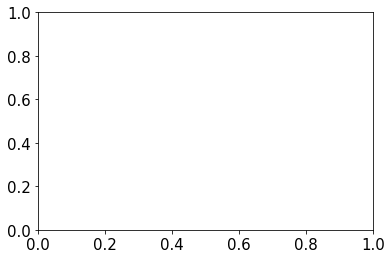

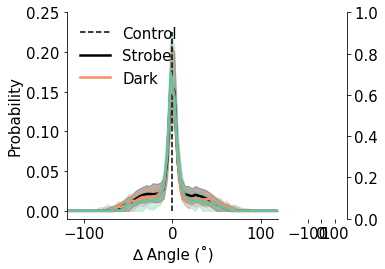

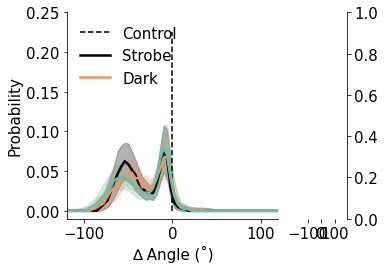

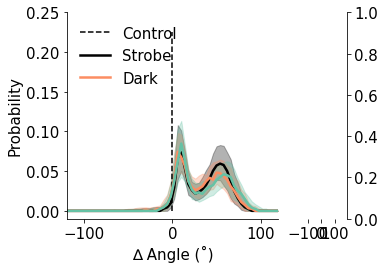

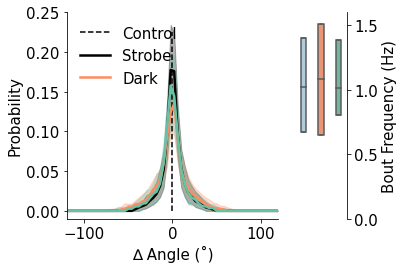

In [11]:
for Direction in ["None","Left", "Right", "Front"]:
    y_store = []
    x_store = []
    conditions = []
    for curr_cond in ['wt','dark', 'strobe']:
        cond_subset = OMR_Runs[OMR_Runs.Condition == curr_cond]
        IDs= np.unique(cond_subset.FishID)
        for fishid in IDs:
            onefish = cond_subset[cond_subset.FishID == fishid]
            onefish.reset_index(level=0, inplace=True)
            (x,y) = sns.histplot(data = onefish.query("Stimulus == '"+Direction+"'"), x = 'OrientationChange',bins = np.arange(-180,180,360/90), hue = 'Condition', stat = 'probability', element = 'poly', fill = False,common_norm=False,palette = [sns.color_palette()[0]],legend = False).get_lines()[-1].get_data()            
            x_store.extend(x)
            y_store.extend(y)
            conditions.extend([curr_cond]*len(y))
    databuff = pd.DataFrame({
        'Probability': y_store,
        'OrientationChange': x_store, 
        'Condition': conditions, 
        })
    plt.cla()
    f, (ax1,ax2) = plt.subplots(1,2, gridspec_kw={'width_ratios': [4, 1]})
    databuff.replace(to_replace = 'wt', value = 'Control',  inplace = True)
    databuff.replace(to_replace = 'strobe', value = 'Strobe',  inplace = True)
    databuff.replace(to_replace = 'dark', value = 'Dark',  inplace = True)
    ax = sns.lineplot(x = 'OrientationChange', y = 'Probability',hue = 'Condition', data = databuff)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set(xlabel = '∆ Angle (˚)')
    sns.despine(top=True)
    plt.cla()
    ColorDict = {'Strobe': sns.color_palette("Set2")[1],'Dark': sns.color_palette("Set2")[0], 'Control': 'k'}
    ax1.plot([0,0],[0,.225],color='k', linestyle='--')

    for condition in ['Control','Strobe', 'Dark']:
        fmri_stats = databuff[databuff.Condition == condition].groupby(['OrientationChange']).describe()

        x = fmri_stats.index
        medians = fmri_stats[('Probability', '50%')]
        medians.name = 'Probability'
        quartiles1 = fmri_stats[('Probability', '25%')]
        quartiles3 = fmri_stats[('Probability', '75%')]

        ax = sns.lineplot(x, medians, color = ColorDict[condition], ax = ax1,linewidth = 2.5)
        print(condition)
        ax.legend(condition) 
        #if condition == 'Control':
        ax.fill_between(x, quartiles1, quartiles3, alpha=0.3, color = ColorDict[condition], label='_nolegend_'); 
    ax.legend(['Control','Strobe','Dark'],frameon=False,loc = 'upper left')
    # if Direction != 'None':
    #     ax.get_legend().remove()
    #     ax.set(xlabel = '',ylabel = '',xlim = [-120,120], ylim = [-0.01,.25],xticks= [])
    #     ax.set(yticks = [],yticklabels=[])
    #     sns.despine(top=True, ax = ax1)
    #     for bounds in ['bottom','left']:
    #         right_side = ax.spines[bounds]
    #         right_side.set_visible(False)
    #         right_side = ax.spines[bounds]
    #         right_side.set_visible(False)
    # else:
    ax.set(xlabel = '∆ Angle (˚)',xlim = [-120,120], ylim = [-0.01,.25])
    sns.despine(top=True, ax = ax1)
    plt.rcParams.update({'font.size': 15})


    
    ax3 = ax2.twinx()
    ax2.set(yticklabels=[], yticks = [])
    data = OMR_Runs.query("Stimulus == '"+Direction+"'")
    data = data[(data.Condition == 'wt')|(data.Condition == 'strobe')|(data.Condition == 'strobe-L')]
    z = data.groupby(['FishID','Condition','Age','Date']).count().reset_index()
    z['BoutFrequency'] =  z['TrialNum']/300
    z.replace(to_replace = 'wt', value = 'Control',  inplace = True)
    z.replace(to_replace = 'strobe', value = 'Strobe',  inplace = True)
    z.replace(to_replace = 'dark', value = 'Dark',  inplace = True)

    ax3 = sns.boxplot(x = 'Condition',y = 'BoutFrequency', data = z,palette = [sns.color_palette('Paired')[0],sns.color_palette("Set2")[1],sns.color_palette("Set2")[0]], ax= ax3, width = 0.3, whis = 0, fliersize = 0)
    # if Direction != 'None':
    #     ax3.set(xticklabels=[],ylabel = '', xticks = [], ylim = [0,1.6],yticks = [])
    #     for bounds in ['left','top','bottom','right']:
    #         right_side = ax3.spines[bounds]
    #         right_side.set_visible(False)
    #         right_side = ax2.spines[bounds]
    #         right_side.set_visible(False)
    # else:
    ax3.set(xticklabels=[],ylabel = 'Bout Frequency (Hz)', xticks = [], ylim = [0,1.6])
    for bounds in ['left','top','bottom']:
        right_side = ax3.spines[bounds]
        right_side.set_visible(False)
        right_side = ax2.spines[bounds]
        right_side.set_visible(False)
        
    f.tight_layout()

    plt.savefig('Figures/Figure1/Probability_BoutFreq_'+Direction+'.pdf')  

Control
Strobe
Dark
Control
Strobe
Dark
Control
Strobe
Dark
Control
Strobe
Dark


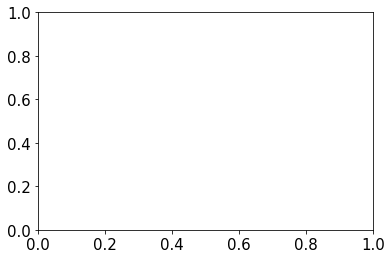

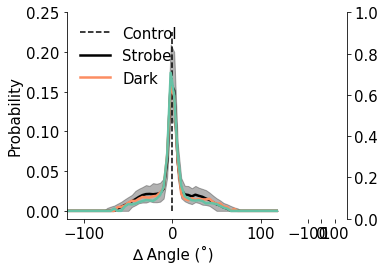

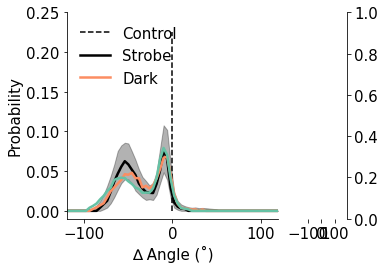

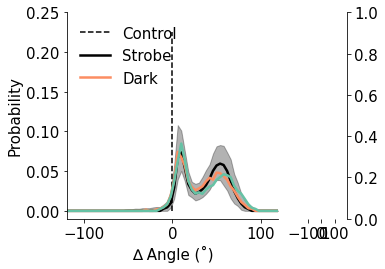

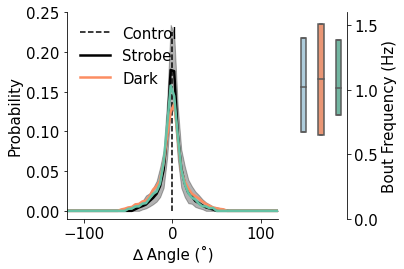

In [12]:
for Direction in ["None","Left", "Right", "Front"]:
    y_store = []
    x_store = []
    conditions = []
    for curr_cond in ['wt','dark', 'strobe']:
        cond_subset = OMR_Runs[OMR_Runs.Condition == curr_cond]
        IDs= np.unique(cond_subset.FishID)
        for fishid in IDs:
            onefish = cond_subset[cond_subset.FishID == fishid]
            onefish.reset_index(level=0, inplace=True)
            (x,y) = sns.histplot(data = onefish.query("Stimulus == '"+Direction+"'"), x = 'OrientationChange',bins = np.arange(-180,180,360/90), hue = 'Condition', stat = 'probability', element = 'poly', fill = False,common_norm=False,palette = [sns.color_palette()[0]],legend = False).get_lines()[-1].get_data()            
            x_store.extend(x)
            y_store.extend(y)
            conditions.extend([curr_cond]*len(y))
    databuff = pd.DataFrame({
        'Probability': y_store,
        'OrientationChange': x_store, 
        'Condition': conditions, 
        })
    plt.cla()
    f, (ax1,ax2) = plt.subplots(1,2, gridspec_kw={'width_ratios': [4, 1]})
    databuff.replace(to_replace = 'wt', value = 'Control',  inplace = True)
    databuff.replace(to_replace = 'strobe', value = 'Strobe',  inplace = True)
    databuff.replace(to_replace = 'dark', value = 'Dark',  inplace = True)
    ax = sns.lineplot(x = 'OrientationChange', y = 'Probability',hue = 'Condition', data = databuff)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set(xlabel = '∆ Angle (˚)')
    sns.despine(top=True)
    plt.cla()
    ColorDict = {'Strobe': sns.color_palette("Set2")[1],'Dark': sns.color_palette("Set2")[0], 'Control': 'k'}
    ax1.plot([0,0],[0,.225],color='k', linestyle='--')

    for condition in ['Control','Strobe', 'Dark']:
        fmri_stats = databuff[databuff.Condition == condition].groupby(['OrientationChange']).describe()

        x = fmri_stats.index
        medians = fmri_stats[('Probability', '50%')]
        medians.name = 'Probability'
        quartiles1 = fmri_stats[('Probability', '25%')]
        quartiles3 = fmri_stats[('Probability', '75%')]

        ax = sns.lineplot(x, medians, color = ColorDict[condition], ax = ax1,linewidth = 2.5)
        print(condition)
        ax.legend(condition) 
        if condition == 'Control':
            ax.fill_between(x, quartiles1, quartiles3, alpha=0.3, color = ColorDict[condition], label='_nolegend_'); 
    ax.legend(['Control','Strobe','Dark'],frameon=False,loc = 'upper left')
    # if Direction != 'None':
    #     ax.get_legend().remove()
    #     ax.set(xlabel = '',ylabel = '',xlim = [-120,120], ylim = [-0.01,.25],xticks= [])
    #     ax.set(yticks = [],yticklabels=[])
    #     sns.despine(top=True, ax = ax1)
    #     for bounds in ['bottom','left']:
    #         right_side = ax.spines[bounds]
    #         right_side.set_visible(False)
    #         right_side = ax.spines[bounds]
    #         right_side.set_visible(False)
    # else:
    ax.set(xlabel = '∆ Angle (˚)',xlim = [-120,120], ylim = [-0.01,.25])
    sns.despine(top=True, ax = ax1)
    plt.rcParams.update({'font.size': 15})


    
    ax3 = ax2.twinx()
    ax2.set(yticklabels=[], yticks = [])
    data = OMR_Runs.query("Stimulus == '"+Direction+"'")
    data = data[(data.Condition == 'wt')|(data.Condition == 'strobe')|(data.Condition == 'strobe-L')]
    z = data.groupby(['FishID','Condition','Age','Date']).count().reset_index()
    z['BoutFrequency'] =  z['TrialNum']/300
    z.replace(to_replace = 'wt', value = 'Control',  inplace = True)
    z.replace(to_replace = 'strobe', value = 'Strobe',  inplace = True)
    z.replace(to_replace = 'dark', value = 'Dark',  inplace = True)

    ax3 = sns.boxplot(x = 'Condition',y = 'BoutFrequency', data = z,palette = [sns.color_palette('Paired')[0],sns.color_palette("Set2")[1],sns.color_palette("Set2")[0]], ax= ax3, width = 0.3, whis = 0, fliersize = 0)
    # if Direction != 'None':
    #     ax3.set(xticklabels=[],ylabel = '', xticks = [], ylim = [0,1.6],yticks = [])
    #     for bounds in ['left','top','bottom','right']:
    #         right_side = ax3.spines[bounds]
    #         right_side.set_visible(False)
    #         right_side = ax2.spines[bounds]
    #         right_side.set_visible(False)
    # else:
    ax3.set(xticklabels=[],ylabel = 'Bout Frequency (Hz)', xticks = [], ylim = [0,1.6])
    for bounds in ['left','top','bottom']:
        right_side = ax3.spines[bounds]
        right_side.set_visible(False)
        right_side = ax2.spines[bounds]
        right_side.set_visible(False)
        
    f.tight_layout()

    plt.savefig('Figures/Figure1/Probability_BoutFreq_All_YesControl_'+Direction+'.pdf')  

# Bout Rates

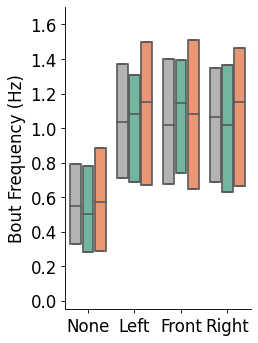

In [90]:
fig = plt.figure(figsize=(3, 5), dpi=80)

data = OMR_Runs[(OMR_Runs.Condition == 'wt')|(OMR_Runs.Condition == 'strobe')|(OMR_Runs.Condition == 'dark')]
z = data.groupby(['FishID','Stimulus','Condition','Age','Date']).count().reset_index()
z['BoutFrequency'] =  z['TrialNum']/300
z.replace(to_replace = 'wt', value = 'Control',  inplace = True)
z.replace(to_replace = 'dark', value = 'Dark',  inplace = True)
z.replace(to_replace = 'strobe', value = 'Strobe',  inplace = True)

ax = sns.boxplot(x = 'Stimulus', hue = 'Condition', y = 'BoutFrequency', fliersize=0, whis = 0, data = z,hue_order=['Control','Dark','Strobe'], order = ['None', 'Left','Front','Right'],palette = [(0.7,0.7,0.7),sns.color_palette("Set2")[0],sns.color_palette("Set2")[1]])#, hue_order = ['None','Front'], order = ['0','0-1','2-3','6-7','24-25','Control'])    

adjust_box_widths(fig, 0.9)
for bounds in ['right','top']:
    right_side = ax.spines[bounds]
    right_side.set_visible(False)
    right_side = ax.spines[bounds]
    right_side.set_visible(False)
ax.set(ylabel = 'Bout Frequency (Hz)', xlabel = '', ylim = [-0.05, 1.7])
ax.get_legend().remove()

plt.savefig('Figures/Figure1/BoutRates.pdf',bbox_inches='tight')  

In [91]:
for i in np.unique(z['Stimulus']):
    to_save = z[z.Stimulus == i]
    to_save.to_csv("Figures/Figure1/RawCSVs/BoutRates_"+i+"Stimulus.csv")

# Correct Turns

Control Dark , pval: 0.0010018459937379475
Control Strobe , pval: 1.3578256029500158e-05
Dark Strobe , pval: 0.47030242659080035


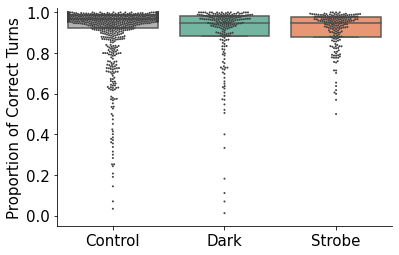

In [99]:
data = OMR_Runs

data = OMR_Runs[(OMR_Runs.Condition == 'wt')|(OMR_Runs.Condition == 'strobe')|(OMR_Runs.Condition == 'dark')]
data = data[data.TrialNum>10]
data.replace(to_replace = 'wt', value = 'Control',  inplace = True)
data.replace(to_replace = 'dark', value = 'Dark',  inplace = True)
data.replace(to_replace = 'strobe', value = 'Strobe',  inplace = True)
# plt.subplot(1,2,1)
Lefts = data[(data.Stimulus == 'Left')]
Lefts['CorrectTurn'] = Lefts.OrientationChange<0;
Lefts['AllTurns'] = np.abs(Lefts.OrientationChange)>0;
Corrects = (Lefts.groupby(['FishID','Condition']).sum()['CorrectTurn']/Lefts.groupby(['FishID','Condition']).sum()['AllTurns']).to_frame().reset_index()
Corrects = Corrects.rename(columns={0: 'CorrectTurn'})


Rights = data[(data.Stimulus == 'Right')]
Rights['CorrectTurn'] = Rights.OrientationChange>0;
Rights['AllTurns'] = np.abs(Rights.OrientationChange)>0;
Corrects2 = (Rights.groupby(['FishID','Condition']).sum()['CorrectTurn']/Rights.groupby(['FishID','Condition']).sum()['AllTurns']).to_frame().reset_index()
Corrects2 = Corrects2.rename(columns={0: 'CorrectTurn'})
Corrects = Corrects.append(Corrects2)

ColorDict = {'Strobe': sns.color_palette("Set2")[1],'Dark': sns.color_palette("Set2")[0], 'Control': (0.7,0.7,0.7)}

ax = sns.boxplot(x = 'Condition',y = 'CorrectTurn', data = Corrects, fliersize=0, whis = 0,palette = ColorDict,order = ['Control','Dark','Strobe'])

sns.swarmplot(x = 'Condition',y = 'CorrectTurn', data = Corrects, size = 2, color='.25',order = ['Control','Dark','Strobe'])
ax.set(ylim= [-0.05, 1.02], xlabel = '', ylabel = 'Proportion of Correct Turns')
for bounds in ['right','top']:
    right_side = ax.spines[bounds]
    right_side.set_visible(False)
    right_side = ax.spines[bounds]
    right_side.set_visible(False)

plt.savefig('Figures/Figure1/CorrectTurns.pdf',bbox_inches='tight')  
conditions = list(np.unique(Corrects['Condition']))
for type1 in range(len(conditions)):
    for type2 in range(type1+1,len(conditions)):
        print(conditions[type1], conditions[type2], ', pval:',  stats.mannwhitneyu(Corrects['CorrectTurn'][Corrects['Condition']==conditions[type1]],Corrects['CorrectTurn'][Corrects['Condition']==conditions[type2]])[1])


In [100]:
print(Corrects.groupby('Condition').median())


           CorrectTurn
Condition             
Control       0.967742
Dark          0.949062
Strobe        0.947758


In [101]:
Corrects.to_csv("Figures/Figure1/RawCSVs/CorrectTurns.csv")

# Cummulative Turns

wt_Right
wt_None
wt_Left
strobe_Right
strobe_None
strobe_Left
dark_Right
dark_None
dark_Left


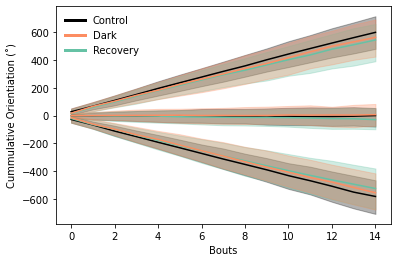

In [10]:
databuff = pd.DataFrame(columns=['OrientationChange','Condition','index'])
OrientationChanges = []
Conditions = []
indices = []
for curr_cond in ['wt','dark','strobe']:
    cond_subset = OMR_Runs[OMR_Runs.Condition == curr_cond]
    IDs= np.unique(cond_subset.FishID)
    for fishid in IDs[:100]:
        onefish = cond_subset[cond_subset.FishID == fishid]
        num_trials = np.unique(onefish.TrialNum)
        for trial in num_trials:
            for curr_stim in ['Left','Right','None']:
                z = onefish[(onefish.TrialNum == trial) & (onefish.Stimulus == curr_stim)]['OrientationChange'].cumsum().reset_index().drop(columns = ['index']).reset_index()
                z['Condition'] = [curr_cond+'_'+curr_stim]*len(z)
                Conditions.extend([curr_cond+'_'+curr_stim]*len(z))
                OrientationChanges.extend(list(z['OrientationChange']))
                indices.extend(list(z['index']))
                #databuff = databuff.append(z)
databuff = pd.DataFrame({
    'index': indices,
    'OrientationChange': OrientationChanges, 
    'Condition': Conditions, 
    })
df2 = (databuff.groupby(['Condition','index']).count())
for (i,j) in df2.index[df2['OrientationChange'] <10].tolist():
    databuff = databuff.drop(databuff[(databuff.Condition == i) & (databuff['index'] == j)].index)

ax = sns.lineplot(x = 'index', y = 'OrientationChange',hue = 'Condition', data = databuff)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.cla()


from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from matplotlib.lines import Line2D

fontprops = fm.FontProperties(size=18)

ColorDict = {'dark': sns.color_palette("Set2")[1],'strobe': sns.color_palette("Set2")[0], 'wt': 'k'}




for condition in np.unique(databuff.Condition)[::-1]:
    fmri_stats = databuff[databuff.Condition == condition].groupby(['index']).describe()

    x = fmri_stats.index[:15]
    medians = fmri_stats[('OrientationChange', '50%')][:15]
    medians.name = 'OrientationChange'
    quartiles1 = fmri_stats[('OrientationChange', '25%')][:15]
    quartiles3 = fmri_stats[('OrientationChange', '75%')][:15]

    ax = sns.lineplot(x, medians, color = ColorDict[condition.split('_')[0]])
    print(condition)
    ax.legend(condition) 
    #if condition[:2] == 'wt':
    ax.fill_between(x, quartiles1, quartiles3, alpha=0.3, color = ColorDict[condition.split('_')[0]]); 
ax.legend(np.unique(databuff.Condition))
ax.set(xlabel = 'Bouts', ylabel = 'Cummulative Orientiation (˚)')

colors = ['k',sns.color_palette("Set2")[1],sns.color_palette("Set2")[0]]
lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in colors]
labels = ['Control', 'Dark', 'Recovery']
plt.legend(lines, labels,frameon=False)



wt_Right
wt_None
wt_Left
strobe_Right
strobe_None
strobe_Left
dark_Right
dark_None
dark_Left


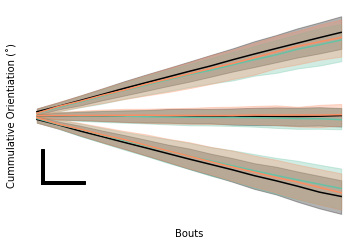

In [12]:
df = {}

for condition in np.unique(databuff.Condition)[::-1]:
    fmri_stats = databuff[databuff.Condition == condition].groupby(['index']).describe()

    x = fmri_stats.index[:15]
    medians = fmri_stats[('OrientationChange', '50%')][:15]
    df[condition] = medians
    medians.name = 'OrientationChange'
    quartiles1 = fmri_stats[('OrientationChange', '25%')][:15]
    quartiles3 = fmri_stats[('OrientationChange', '75%')][:15]

    ax = sns.lineplot(x, medians, color = ColorDict[condition.split('_')[0]])
    print(condition)
    ax.legend(condition) 
    #if condition[:2] == 'wt':
    ax.fill_between(x, quartiles1, quartiles3, alpha=0.3, color = ColorDict[condition.split('_')[0]]);
    df[condition+'_q1'] = quartiles1
    df[condition + '_q3'] = quartiles3
ax.set(xlabel = 'Bouts', ylabel = 'Cummulative Orientiation (˚)')
ax.set(xticks = [], yticks = [])
sns.despine(top=True, bottom = True, left = True)
scalebar = AnchoredSizeBar(ax.transData,
                           2, '', 'lower left', 
                           pad=1,
                           color='k',
                           frameon=False,
                           size_vertical=20,
                           fontproperties=fontprops)

scalebar2 = AnchoredSizeBar(ax.transData,
                           0.1, '', 'lower left', 
                           pad=1,
                           color='k',
                           frameon=False,
                           size_vertical=250,
                           fontproperties=fontprops)

ax.add_artist(scalebar)
ax.add_artist(scalebar2)
ax.get_legend().remove()



plt.savefig('Figures/Figure1/CummDist_All.pdf',bbox_inches='tight')  


In [152]:
df = pd.DataFrame(df)
df.to_csv("Figures/Figure1/CummulativeTurns.csv")

In [13]:
df

{'wt_Right': index
 0      27.440184
 1      66.873358
 2     109.019474
 3     151.820178
 4     195.463002
 5     236.513989
 6     277.390160
 7     318.495174
 8     358.114230
 9     402.082749
 10    443.553653
 11    483.378168
 12    522.778131
 13    561.855901
 14    599.904845
 Name: OrientationChange, dtype: float64,
 'wt_Right_q1': index
 0       4.009954
 1      44.689777
 2      73.315200
 3     109.832536
 4     143.584985
 5     177.286329
 6     211.627323
 7     244.257330
 8     280.245724
 9     317.184398
 10    349.775190
 11    383.982493
 12    418.906625
 13    448.025344
 14    480.731709
 Name: (OrientationChange, 25%), dtype: float64,
 'wt_Right_q3': index
 0      50.903814
 1      96.431080
 2     144.867054
 3     195.106392
 4     246.645845
 5     294.833315
 6     341.056716
 7     388.841957
 8     436.997739
 9     484.383923
 10    535.977403
 11    580.291411
 12    629.616047
 13    672.034096
 14    716.123357
 Name: (OrientationChange, 75%), dty